In [1]:
from Neuron_analysis_tool.Analyzer import Analyzer, long_pulse_protocol
from Neuron_analysis_tool.utils import video_player
from pathlib import Path
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## loading cell from ASC file format

In [2]:

dir_path = os.path.abspath('')
morph_path=os.path.join(dir_path,'data/morph.ASC')

analyser = Analyzer(type='ASC', morph_path=morph_path)



17089 lines read

/ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/data/morph.ASC problems


Main branch starting at line 305 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 3635 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


## plot the cell morphology

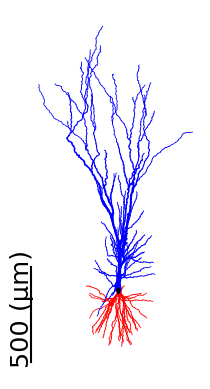

In [3]:
_,_,_=analyser.plot_morph(scale=500, diam_factor=0.5, theta=-75)

## create a somaticentric view card 

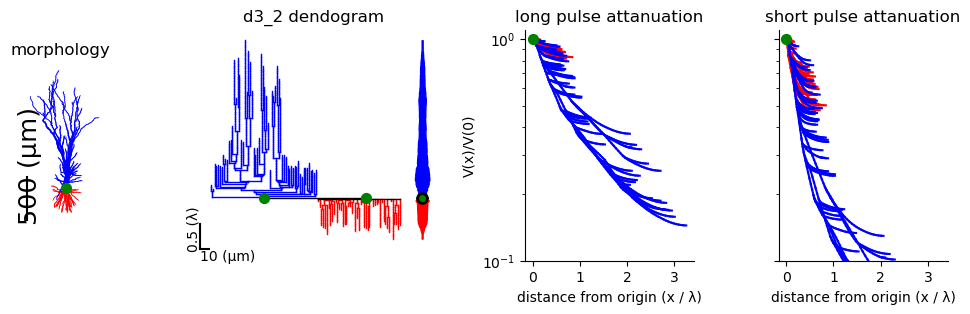

In [4]:
fig, ax = analyser.create_card(theta=-75, diam_factor=0.5)

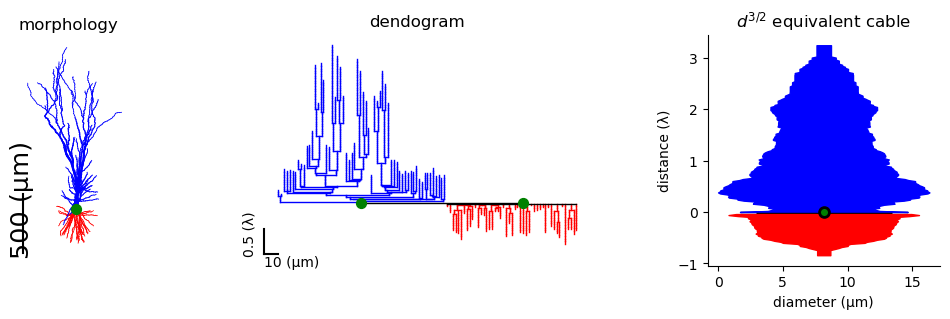

In [5]:
fig, ax = analyser.create_morpho_card(theta=-75, diam_factor=0.5)

## create a spasific segment centric view card

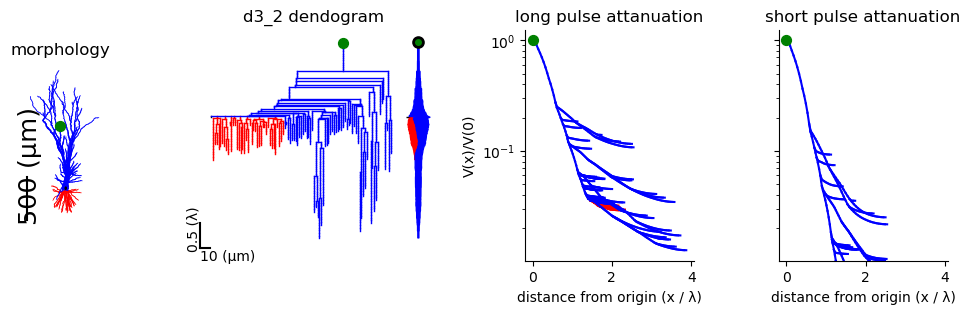

In [6]:
fig, ax = analyser.create_card(start_seg=list(analyser.cell.apic[101])[-1], theta=-75, diam_factor=0.5)

## defining a seg value function and flot the result on the cell morphology

#### here we show that the first bifurcation in the apical tree impose a frequncy gating for signal passing to the relative hot spot
#### we start by difining a function that gives the transfer impadance between 2 segments and then calculating it for all the segments with respect to the hot spot (1/2/3), the hot spot position is marked by a red circle

In [8]:
hot_spots = [list(analyser.cell.apic[43])[-1], list(analyser.cell.apic[64])[-1], list(analyser.cell.apic[77])[-1]]

freqs = np.concatenate([np.arange(0, 1, 0.05), np.arange(1, 10, 0.1), np.arange(10, 1000,1)])
def transfer_freq(seg1, seg2, freqs = freqs):
    imp = h.Impedance(seg1.x, sec=seg1.sec)
    imp.loc(seg1.x, sec=seg1.sec)
    transfer = []
    for freq in freqs:
        imp.compute(freq)
        transfer.append(imp.transfer(seg2.x, sec=seg2.sec))
    return freqs, np.array(transfer)


apical: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1805/1805 [05:11<00:00,  5.80it/s]
axon: 0it [00:00, ?it/s]
else: 0it [00:00, ?it/s]
optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 28857.06it/s]


Text(0, 0.5, 'f_half (Hz)')

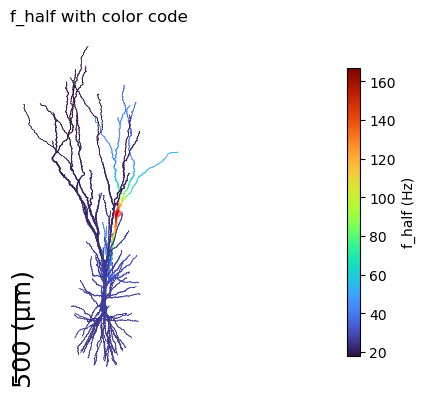

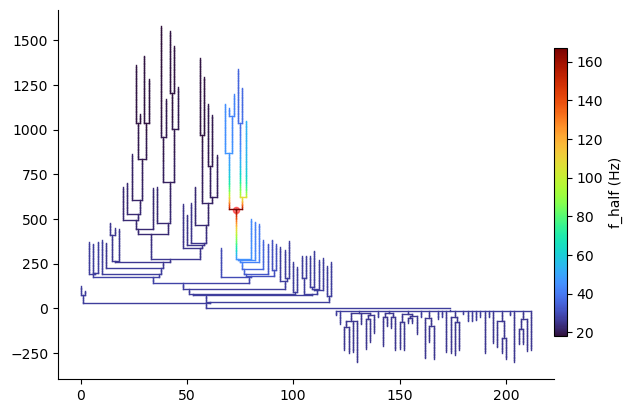

In [10]:

def f_half(seg):
    f, R_tr = transfer_freq(seg, hot_spots[0])
    f_half = f[R_tr<(R_tr.max()-R_tr.min())/2][0]
    return f_half

seg_to_indicate_dict={hot_spots[0]:dict(color='r', alpha=0.5, size=20)}
plt.title('f_half with color code')
ax, color_bar, colors, lines, segs=analyser.plot_morph_with_value_func(func = f_half, run_time=1000, theta=-75, scale=500, 
                                                          diam_factor=0.5, seg_to_indicate_dict=seg_to_indicate_dict)#, colors=colors)
color_bar.set_ylabel('f_half (Hz)')

plt.figure()
ax, x_pos, cax, colors, lines, segs = analyser.plot_dendogram_with_value_func(func = None, diam_factor=None, colors=colors, 
                                                                 segs_to_indecate=seg_to_indicate_dict)
cax.set_ylabel('f_half (Hz)')


apical: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1805/1805 [05:10<00:00,  5.82it/s]
axon: 0it [00:00, ?it/s]
else: 0it [00:00, ?it/s]
optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 28241.93it/s]


Text(0, 0.5, 'f_half (Hz)')

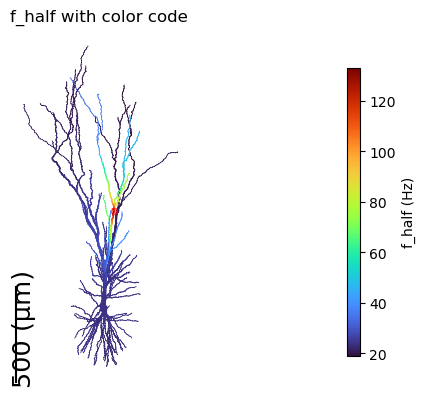

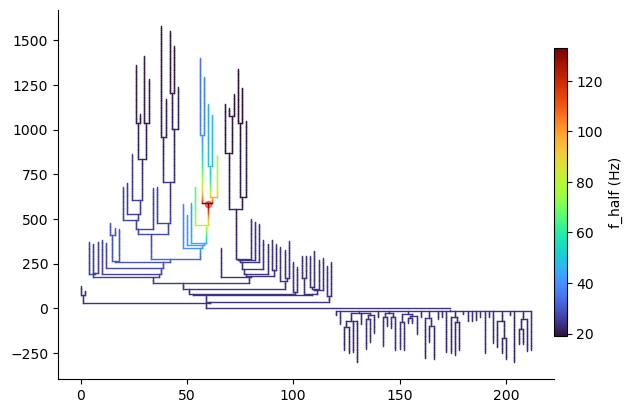

In [11]:
def f_half(seg):
    f, R_tr = transfer_freq(seg, hot_spots[1])
    f_half = f[R_tr<(R_tr.max()-R_tr.min())/2][0]
    return f_half

seg_to_indicate_dict={hot_spots[1]:dict(color='r', alpha=0.5, size=20)}
plt.title('f_half with color code')
ax, color_bar, colors, lines, segs=analyser.plot_morph_with_value_func(func = f_half, run_time=1000, theta=-75, scale=500, 
                                                          diam_factor=0.5, seg_to_indicate_dict=seg_to_indicate_dict)
color_bar.set_ylabel('f_half (Hz)')

plt.figure()
ax, x_pos, cax, colors, lines, segs = analyser.plot_dendogram_with_value_func(func = None, diam_factor=None, colors=colors, 
                                                                 segs_to_indecate=seg_to_indicate_dict)
cax.set_ylabel('f_half (Hz)')


apical: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1805/1805 [04:57<00:00,  6.06it/s]
axon: 0it [00:00, ?it/s]
else: 0it [00:00, ?it/s]
optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 29855.54it/s]


Text(0, 0.5, 'f_half (Hz)')

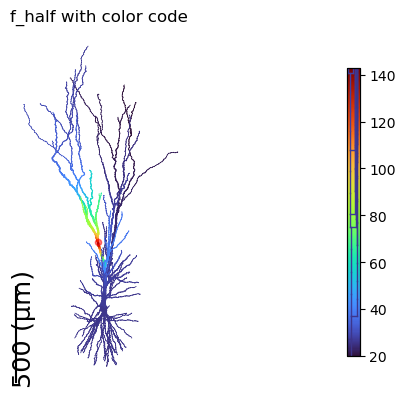

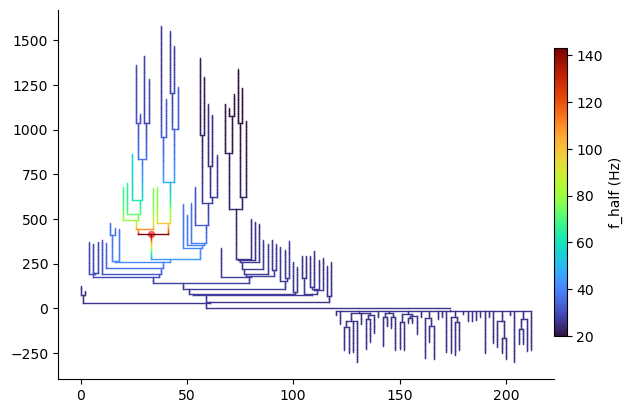

In [12]:
def f_half(seg):
    f, R_tr = transfer_freq(seg, hot_spots[2])
    f_half = f[R_tr<(R_tr.max()-R_tr.min())/2][0]
    return f_half

seg_to_indicate_dict={hot_spots[2]:dict(color='r', alpha=0.5, size=20)}
plt.title('f_half with color code')
ax, color_bar, colors, lines, segs=analyser.plot_morph_with_value_func(func = f_half, run_time=1000, theta=-75, scale=500, 
                                                          diam_factor=0.5, seg_to_indicate_dict=seg_to_indicate_dict)
color_bar.set_ylabel('f_half (Hz)')

plt.figure()
ax, x_pos, cax, colors, lines, segs = analyser.plot_dendogram_with_value_func(func = None, diam_factor=None, colors=colors, 
                                                                 segs_to_indecate=seg_to_indicate_dict)
cax.set_ylabel('f_half (Hz)')


## creating a movie of voltage response to a somatic stimulated spikes

#### creating a video
##### videos have 5 plot options:
##### ---------1) morphology: the recorded value will be showen on the morphology with color code
##### ---------2) dendogram: the recorded value will be showen on the dendogram with color code
##### ---------3) attenuation: the record will be shown in color code acording to its distance from a selected seg
##### ---------4) all_records: plot all the records on a runing time plot
##### ---------5) single_record: plot a selected seg record on a runing time plot
##### any combination of this graphs can be created
##### Note that this movie making function can take time!!!


In [4]:
records, extra = analyser.record_protocol(cut_start_ms=1000.0, record_names=['v'])


duration= 30.998750000112775
Moviepy - Building video videos/passive_morph/spiking_morph_dendogram_and_voltage.mp4.
Moviepy - Writing video videos/passive_morph/spiking_morph_dendogram_and_voltage.mp4



Moviepy - Done !
Moviepy - video ready videos/passive_morph/spiking_morph_dendogram_and_voltage.mp4


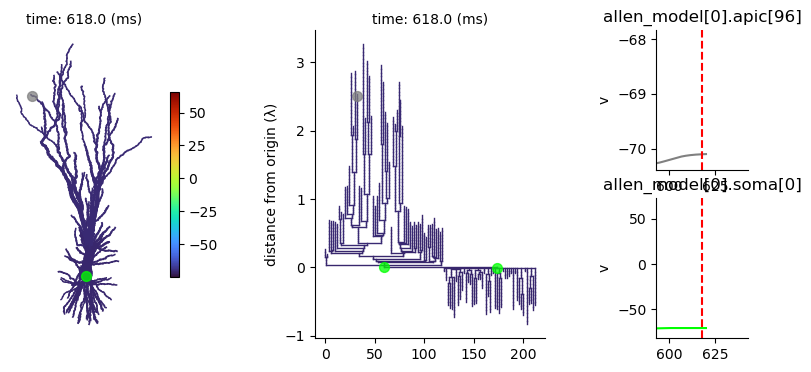

In [5]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(10, 4))
plt.tight_layout()
gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.4])
ax_morph = fig.add_subplot(gs[:, 0])
ax_dendogram = fig.add_subplot(gs[:, 1])
ax_soma_voltage = fig.add_subplot(gs[1, 2])
ax_tip_voltage = fig.add_subplot(gs[0, 2])
f = lambda: plt.subplots_adjust(wspace=0.6)
f()

seg_to_indicate_dict = dict()
seg_to_indicate_dict[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
seg_to_indicate_dict[list(analyser.cell.apic[96])[-1]] = dict(label='tip', alpha=0.75, color='grey', size=50)

start_seg = list(analyser.cell.soma[0])[0]
slow_down_factor=50
plot_kwargs=[dict(ax=ax_morph, seg = start_seg, 
                  records=records.all_records['v'], 
                  electrical=False, 
                  plot_type='morph', 
                  seg_to_indicate_dict=seg_to_indicate_dict,
                  plot_color_bar=True, 
                  theta=-75,
                  diam_factor=1)]

plot_kwargs.append(dict(ax=ax_dendogram, 
                        seg = start_seg, 
                        records=records.all_records['v'], 
                        electrical=True, 
                        plot_type='dendogram', 
                        seg_to_indicate_dict=seg_to_indicate_dict,
                        plot_color_bar=False, ))

plot_kwargs.append(dict(ax=ax_soma_voltage, 
                        seg = start_seg, 
                        records=records.all_records['v'], 
                        plot_type='single_record', color='lime'))
                   

plot_kwargs.append(dict(ax=ax_tip_voltage, 
                        seg = list(analyser.cell.apic[96])[-1], 
                        records=records.all_records['v'], 
                        plot_type='single_record', color='grey'))


videos_folder = 'videos/passive_morph/'
video_name = 'spiking_morph_dendogram_and_voltage.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs,f=[f], 
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')

video_player(Path.cwd(), videos_folder+video_name)